# Anomaly Detection Challenge 4
## Miguel Sandim and Paula Fortuna

## 0 - Library Imports & Utils

In [1]:
# json
import json

# math
import math

# pandas
import pandas as pd
from pandas import Series,DataFrame

# numpy, matplotlib, seaborn
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Random libraries and seeds:
import random
random.seed(2)
np.random.seed(2)

pd.set_option('display.max_columns', None)

In [2]:
# From: http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
import itertools
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


# 1 - Data Reading

### 1.1 Load data

In [3]:
def readData(filename):
    data = []
    with open(filename) as f:
        for line in f:
            data.append(json.loads(line))
            
    return pd.io.json.json_normalize(data)

In [4]:
train_df = readData("data/training_set_dedup.csv")

In [5]:
test_df = readData("data/test_set_dedup.csv")

### Save data for Paula:

In [ ]:
train_df.to_csv("train_df.csv", index = False, encoding='utf-8')

In [ ]:
test_df.to_csv("test_df.csv", index = False, encoding='utf-8')

### Some statistics:

In [6]:
train_df["label"].value_counts()

malicious    5000
benign       4754
Name: label, dtype: int64

In [7]:
5000/(5000 + 4754)

0.5126102111954071

## About 51% of our dataset are anomalous cases.

# 2 - Data Pre-Processing

In [8]:
import sklearn.preprocessing as skpre

## 2.1 - Solve Missing Values

No missing values exist!

## 2.2 - Feature Extraction

Change label to numeric

In [11]:
train_df["label_numeric"] = train_df.apply(lambda x: 1 if x["label"] == "malicious" else 0, axis=1)

In [12]:
def has_debug(data, column_name):
    data["has_debug"] = data.apply(lambda x: 1 if (type(x[column_name]) is list) else 0, axis=1)

has_debug(train_df, "results.peinfo.debug")
has_debug(test_df, "peinfo.debug")

In [13]:
def size_imports(data, column_name):
    data["size_imports"] = data.apply(lambda x: len(x[column_name])
                                          if (type(x[column_name]) is list) else 0, axis=1)

size_imports(train_df, "results.peinfo.imports")
size_imports(test_df, "peinfo.imports")

In [14]:
def size_exports(data, column_name):
    data["size_exports"] = data.apply(lambda x: len(x[column_name])
                                          if (type(x[column_name]) is list) else 0, axis=1)

size_exports(train_df, "results.peinfo.exports")
size_exports(test_df, "peinfo.exports")

In [15]:
def pe_section_mean_size(data, column_name):
    data["pe_section_mean_size"] = data.apply(lambda x: np.mean([y["size"] for y in x[column_name]])
                                          if (type(x[column_name]) is list and 
                                              len(x[column_name]) > 0) else 0, axis=1)

pe_section_mean_size(train_df, "results.peinfo.pe_sections")
pe_section_mean_size(test_df, "peinfo.pe_sections")

In [16]:
def pe_section_mean_virtual_size(data, column_name):
    data["pe_section_mean_virtual_size"] = data.apply(lambda x: np.mean([y["virt_size"] for y in x[column_name]])
                                          if (type(x[column_name]) is list and 
                                              len(x[column_name]) > 0) else 0, axis=1)

pe_section_mean_virtual_size(train_df, "results.peinfo.pe_sections")
pe_section_mean_virtual_size(test_df, "peinfo.pe_sections")

In [17]:
def pe_section_mean_entropy(data, column_name):
    data["pe_section_mean_entropy"] = data.apply(lambda x: np.mean([y["entropy"] for y in x[column_name]])
                                          if (type(x[column_name]) is list and 
                                              len(x[column_name]) > 0) else 0, axis=1)

pe_section_mean_entropy(train_df, "results.peinfo.pe_sections")
pe_section_mean_entropy(test_df, "peinfo.pe_sections")

In [18]:
# results.peinfo.rich_header.checksum is already calculated
train_df = train_df.rename(columns = {'results.peinfo.rich_header.checksum':'peinfo.rich_header.checksum'})

In [19]:
def rich_header_size_values_parsed(data, column_name):
    data["rich_header_size_values_parsed"] = data.apply(lambda x: len(x[column_name])
                                          if (type(x[column_name]) is list) else 0, axis=1)

rich_header_size_values_parsed(train_df, "results.peinfo.rich_header.values_parsed")
rich_header_size_values_parsed(test_df, "peinfo.rich_header.values_parsed")

In [20]:
def rich_header_size_values_raw(data, column_name):
    data["rich_header_size_values_raw"] = data.apply(lambda x: len(x[column_name])
                                          if (type(x[column_name]) is list) else 0, axis=1)

#rich_header_size_values_raw(train_df, "results.peinfo.rich_header.values_raw")
#rich_header_size_values_raw(test_df, "peinfo.rich_header.values_raw")

In [21]:
train_df.groupby(['label']).mean()

,results.peinfo.rich_header,peinfo.rich_header.checksum,results.peinfo.timestamp.timestamp,label_numeric,has_debug,size_imports,size_exports,pe_section_mean_size,pe_section_mean_virtual_size,pe_section_mean_entropy,rich_header_size_values_parsed
label,,,,,,,,,,,
benign,NaN,2.192955e+09,1.065898e+09,0.0,0.809634,107.287547,38.519773,67472.626526,69089.419439,3.756720,6.311527
malicious,NaN,2.166347e+09,1.223420e+09,1.0,0.117400,134.430600,2.790800,313722.160558,169368.557166,4.362899,5.777800


## 2.4 Sampling

### 2.4.1 Undersampling

In [22]:
def undersampling(data):
    ids_to_sample = data[data["label"] == 0].index.values
    sample_size = data[data["label"] == 1].shape[0]
    anomalies = data[data["label"] == 1].index.values
    
    final_ids = np.append(np.random.choice(ids_to_sample, size = sample_size), anomalies)
    #print(ids_to_sample)
    #data[fake_review]
    return data.iloc[final_ids]
    
#train_df = undersampling(train_df)  

### 2.4.2 Oversampling

In [23]:
def oversampling(data):
    anomalies = data[data["fake_review"] == "Y"]
    data = data.append(anomalies)
    data = data.append(anomalies)
    data = data.append(anomalies)
    data = data.append(anomalies)
    data = data.append(anomalies)
    data = data.append(anomalies)
    return data

#train_df_joined = oversampling(train_df_joined)  

In [24]:
train_df.columns

Index(['label', 'results.peinfo.debug', 'results.peinfo.error',
       'results.peinfo.exports', 'results.peinfo.imphash',
       'results.peinfo.imports', 'results.peinfo.pe_sections',
       'results.peinfo.pehash', 'results.peinfo.rich_header',
       'peinfo.rich_header.checksum', 'results.peinfo.rich_header.sha256',
       'results.peinfo.rich_header.values_parsed',
       'results.peinfo.rich_header.values_raw',
       'results.peinfo.thread_local_storage',
       'results.peinfo.timestamp.human_timestamp',
       'results.peinfo.timestamp.timestamp', 'results.peinfo.version_info',
       'results.peinfo.version_var', 'results.sha256', 'sha256',
       'label_numeric', 'has_debug', 'size_imports', 'size_exports',
       'pe_section_mean_size', 'pe_section_mean_virtual_size',
       'pe_section_mean_entropy', 'rich_header_size_values_parsed'],
      dtype='object')

## 2.5 Define global variables for the model

In [25]:
def encodeVariables():
    
    target_variable = "label_numeric" # target variable
    
    dropVariableListTrain = [
        
        ### All variables in this list will be deleted
        "results.peinfo.debug",
        "results.peinfo.error",
        "results.peinfo.exports",
        "results.peinfo.imphash",
        "results.peinfo.imports",
        "results.peinfo.pe_sections",
        "results.peinfo.pehash",
        "results.peinfo.rich_header",
        "results.peinfo.rich_header.sha256",
        "results.peinfo.rich_header.values_parsed",
        "results.peinfo.rich_header.values_raw",
        "results.peinfo.thread_local_storage",
        "results.peinfo.timestamp.human_timestamp",
        "results.peinfo.timestamp.timestamp",
        "results.peinfo.version_info",
        "results.peinfo.version_var",
        "results.sha256",
        "sha256",
        "peinfo.rich_header.checksum"
        ]
    
    dropVariableListTest = [
        
        ### All variables in this list will be deleted
        "peinfo.debug",
        "peinfo.error",
        "peinfo.exports",
        "peinfo.imphash",
        "peinfo.imports",
        "peinfo.pe_sections",
        "peinfo.pehash",
        "peinfo.rich_header",
        "peinfo.rich_header.sha256",
        "peinfo.rich_header.values_parsed",
        "peinfo.rich_header.values_raw",
        "peinfo.thread_local_storage",
        "peinfo.timestamp.human_timestamp",
        "peinfo.timestamp.timestamp",
        "peinfo.version_info",
        "peinfo.version_var",
        "sha256",
        "peinfo.rich_header.checksum"
        ]
 
    # Drop variables in the X_train:
    X_train = train_df.drop(dropVariableListTrain, axis=1)
    
    # Drop target variables in the X_train:
    X_train = X_train.drop([target_variable, "label"], axis=1)
    
    # Drop variables in the X_test:
    X_test = test_df.drop(dropVariableListTest, axis=1)
    
    # Drop variables in the Y_train:
    Y_train = train_df[target_variable]

    # The following variables are categorical:
    # - proto
    # - service
    # - state
    # - attack_cat (we're not using this one)
    # - label
    
    # Transform categorical variables for X_train:
    categoricalVariableList = [
        #"proto",
        #"service",
        #"state"
    ]
    
    # Number of dimensions must be the same in X_train and X_test
    assert X_train.shape[1] == X_test.shape[1]
    
    # Apply dummy variables
    #X_all = X_train.append(X_test)
    #X_all = pd.get_dummies(X_all, columns = categoricalVariableList)
    
    #X_train = X_all.iloc[np.arange(0, X_train.shape[0]), :]
    #X_test = X_all.iloc[np.arange(X_train.shape[0], X_all.shape[0]), :]
    
    return X_train, Y_train, X_test

#train_df_joined = train_df_joined.iloc[np.random.permutation(len(train_df_joined))]

X_train, Y_train, X_test = encodeVariables()

In [26]:
X_train.shape

(9754, 7)

In [27]:
train_df.shape

(9754, 28)

In [28]:
X_test.shape

(46784, 7)

In [29]:
test_df.shape

(46784, 25)

In [30]:
X_train.columns.values

array(['has_debug', 'size_imports', 'size_exports', 'pe_section_mean_size',
       'pe_section_mean_virtual_size', 'pe_section_mean_entropy',
       'rich_header_size_values_parsed'], dtype=object)

In [31]:
X_train

,has_debug,size_imports,size_exports,pe_section_mean_size,pe_section_mean_virtual_size,pe_section_mean_entropy,rich_header_size_values_parsed
0,1,118,4,34986.666667,36632.333333,4.210211,10
1,1,144,0,18602.666667,20263.333333,4.140469,7
2,1,125,2,27340.800000,27105.800000,4.776475,11
3,1,101,35,16998.400000,20393.600000,2.950164,7
4,1,262,9,86016.000000,92120.666667,4.728660,10
5,0,0,0,2048.000000,4096.000000,3.691530,2
6,1,72,0,5632.000000,5687.333333,3.101004,7
7,1,273,4,63104.000000,63602.250000,5.398655,9
8,1,47,3,2048.000000,1805.500000,3.787006,11
9,1,60,0,17510.400000,17591.200000,4.146200,9


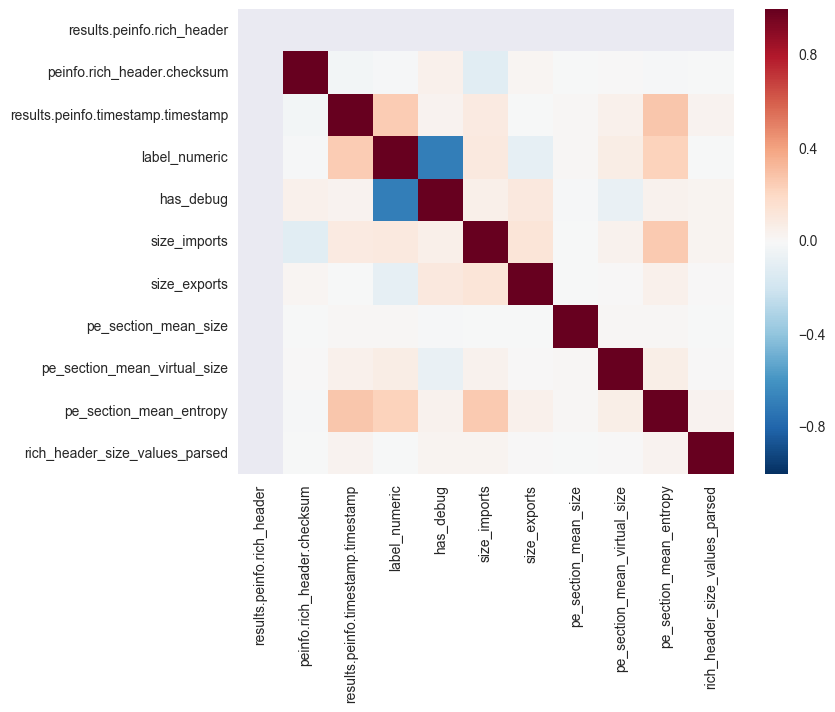

In [32]:
def plotCorrelations(data):
    plt.figure(figsize=(8, 6), dpi=500)
    corr = data.corr()
    sns.heatmap(corr, 
                xticklabels=corr.columns.values,
                yticklabels=corr.columns.values)
    
plotCorrelations(train_df)

In [33]:
import sklearn.decomposition

def performPCA():
    global X_train
    global X_test
    pca = sklearn.decomposition.PCA(n_components = 30)
    pca.fit(X_train)
    X_train = pca.transform(X_train)
    X_test = pca.transform(X_test)
    
#performPCA()

### Normalize features

In [34]:
def featureNormalization():
    global X_train
    global X_test
    
    scaler = skpre.StandardScaler().fit(X_train)
    X_train = scaler.transform(X_train)
    X_test = scaler.transform(X_test)
    
#featureNormalization()

## 3.1 - Model selection based on which models do best in CV using default settings:

In [35]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(random_state = 2).fit(X_train, Y_train)

In [36]:
X_train.columns.values

array(['has_debug', 'size_imports', 'size_exports', 'pe_section_mean_size',
       'pe_section_mean_virtual_size', 'pe_section_mean_entropy',
       'rich_header_size_values_parsed'], dtype=object)

In [37]:
rf.feature_importances_

array([ 0.28242316,  0.16480864,  0.1647912 ,  0.05645114,  0.10856051,
        0.08033726,  0.14262809])

In [38]:
fe_v = rf.feature_importances_

fe_n = X_train.columns.values

assert len(fe_v) == len(fe_n)

features = []
for i in range(0, len(fe_v)):
    features.append((fe_v[i], fe_n[i]))
    
features.sort(key = lambda x: x[0], reverse = True)
features

[(0.28242316224416075, 'has_debug'),
 (0.16480863875447974, 'size_imports'),
 (0.16479119733744765, 'size_exports'),
 (0.14262809161328721, 'rich_header_size_values_parsed'),
 (0.10856050973136103, 'pe_section_mean_virtual_size'),
 (0.080337256593893902, 'pe_section_mean_entropy'),
 (0.056451143725369711, 'pe_section_mean_size')]

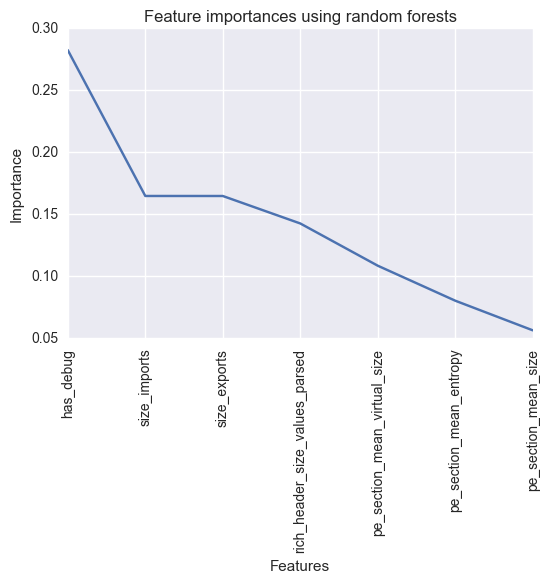

In [53]:
plt.plot([x[0] for x in features])
plt.title("Feature importances using random forests")

plt.xticks(np.arange(len([x[1] for x in features])), [x[1] for x in features], rotation='vertical')
plt.ylabel('Importance')
plt.xlabel('Features')
plt.show()

LR: 0.757370 (0.027416)
LDA: 0.917961 (0.010895)
KNN: 0.865671 (0.015185)
CART: 0.954699 (0.005780)
NB: 0.591067 (0.049244)
NN: 0.727244 (0.069530)
RF-normal: 0.990231 (0.002644)
RF-tuned: 0.992898 (0.001707)
AB: 0.985295 (0.003831)


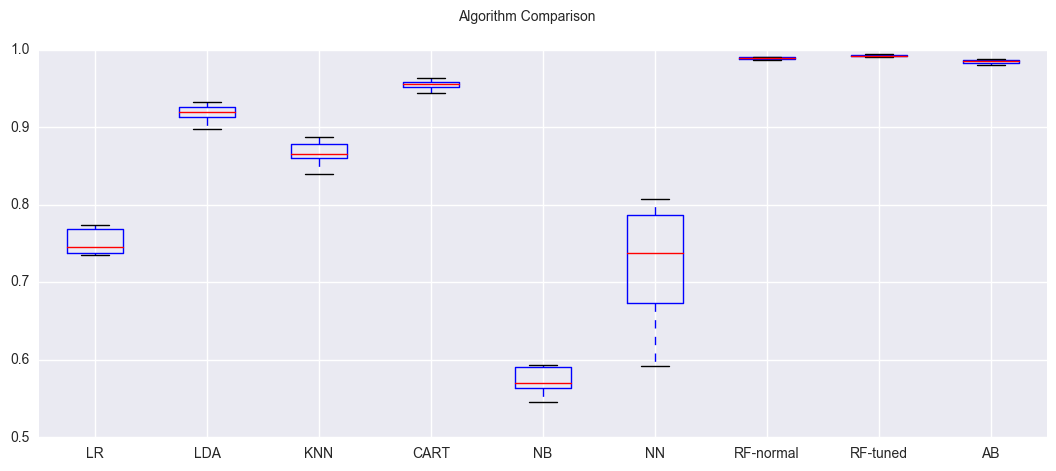

In [54]:
#inspired in http://machinelearningmastery.com/compare-machine-learning-algorithms-python-scikit-learn/

import sklearn.model_selection as mds
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
#import xgboost as xgb

def modelSelection():

    # prepare data

    #Y_train = train_df[:,-1]
    #X_train = train_df[:,:-1]

    #Y_train = train_df[len(train_df.columns)-1]
    #X_train = train_df.drop(len(train_df.columns)-1,axis=1)

    # prepare configuration for cross validation test harness
    num_folds = 10

    # prepare models
    models = []
    models.append(('LR', LogisticRegression(random_state = 2)))
    models.append(('LDA', LinearDiscriminantAnalysis()))
    models.append(('KNN', KNeighborsClassifier()))
    models.append(('CART', DecisionTreeClassifier(random_state = 2)))
    models.append(('NB', GaussianNB()))
    #models.append(('SVM-Linear', SVC(kernel="linear")))
    #models.append(('SVM-Poly', SVC(kernel="poly")))
    #models.append(('SVM-RBF', SVC(kernel="rbf", random_state = 2)))
    models.append(('NN', MLPClassifier(random_state = 2)))
    models.append(('RF-normal', RandomForestClassifier(random_state = 2)))
    models.append(('RF-tuned', RandomForestClassifier(criterion="entropy", n_estimators=47, random_state = 2)))
    models.append(('AB', AdaBoostClassifier(random_state = 2)))
    #models.append(('XGB', xgb.XGBClassifier()))

    # evaluate each model in turn
    results = []
    scoring = 'roc_auc' # try with 'roc_auc', f1'

    for model_name, model in models:
        kfold = mds.StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=2)
        cv_results = mds.cross_val_score(model, X_train, Y_train, cv=kfold, scoring=scoring)
        results.append({"name": model_name, "cv_results": cv_results, "mean": cv_results.mean(), "std": cv_results.std()})
        print("%s: %f (%f)" % (model_name, cv_results.mean(), cv_results.std()))

    # boxplot algorithm comparison
    fig = plt.figure(figsize=(13, 5), dpi=500)
    fig.suptitle('Algorithm Comparison')
    ax = fig.add_subplot(111)
    plt.boxplot([x["cv_results"] for x in results])
    ax.set_xticklabels([x["name"] for x in results])
    plt.show()

    # order the models by the mean auc
    #results_by_strategy.sort(key=lambda x: x["mean"], reverse=True)
    #print([(x["name"], x["mean"]) for x in results])

modelSelection()

# 4 - Submission to Kaggle

In [ ]:
from sklearn.ensemble import RandomForestClassifier

######################################
# Function Save Data To CSV
######################################
def saveDataToCSV(ids, Y_pred):
    submission = pd.DataFrame({
        "sha256": ids,
        "label": Y_pred
    })
    submission = submission[['sha256', 'label']]
    submission.to_csv('submission.csv', index=False)

# choose algorithm
def makeSubmissionKaggle(algorithm):
    global test_df
    
    algorithm.fit(X_train, Y_train)
    Y_pred = algorithm.predict(X_test)
    Y_pred = Y_pred.astype(int)
    Y_pred = ["malicious" if y == 1 else "benign" for y in Y_pred]

    # save data to CSV
    saveDataToCSV(test_df["sha256"].values, Y_pred)
    
#def makeSubmissionAnomalyKaggle(algorithm):
#    algorithm.fit(X_train, Y_train)
#    Y_pred = algorithm.predict(X_test)
#    Y_pred = Y_pred.astype(int)
#    Y_pred = [1 if x == 1 else 0 for x in Y_pred]

    # save data to CSV
#    saveDataToCSV(df_test, Y_pred)
    
#makeSubmissionKaggle("07-spec-mean", xgb.XGBClassifier( learning_rate=0.01, n_estimators=5000, max_depth=7,
#                      min_child_weight=1, gamma=0, subsample=0.55, colsample_bytree=0.85,
#                      reg_alpha=1e-5, objective= 'binary:logistic', scale_pos_weight=1, seed=2))

makeSubmissionKaggle(RandomForestClassifier(criterion="entropy", n_estimators=47, random_state = 2))
#makeSubmissionKaggle(xgb.XGBClassifier())

#makeSubmissionKaggle("09-spec-min", LinearDiscriminantAnalysis(n_components = 1, shrinkage = "auto", solver="lsqr"))
#makeSubmissionKaggle(RandomForestClassifier(criterion = 'entropy', max_features = 'log2', n_estimators = 630))
#makeSubmissionKaggle(RandomForestClassifier(criterion = 'entropy', max_features = 'log2', n_estimators = 310))
#makeSubmissionAnomalyKaggle(svm.OneClassSVM(nu=0.07, kernel="linear", gamma=0.1, random_state = 2))
#makeSubmissionKaggle(svm.OneClassSVM(nu=0.07, kernel="poly", gamma=0.1, random_state = 2))
#makeSubmissionAnomalyKaggle(sklearn.ensemble.IsolationForest(contamination = 0.4, random_state = 2))
#makeSubmissionKaggle(RandomForestClassifier())